In [1]:
from pathlib import Path
import pandas as pd
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler
from torch.optim import lr_scheduler
import torch.optim as optim
from torchvision.transforms import transforms
from torchvision.models.resnet import Bottleneck, ResNet
import matplotlib.pyplot as plt
from torchvision.transforms.functional import get_image_size
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np

In [2]:
def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

In [3]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, data_df, transform=None):
        self.data_dir = data_dir
        self.labels_df = data_df
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_path = self.data_dir / f"img_{self.labels_df.iloc[idx]['id']}.png"
        image = Image.open(img_path).convert('RGB')
        label = self.labels_df.iloc[idx]['malignant']

        if self.transform:
            image = self.transform(image)
        sample = {'image': image,
                  'label': label,
                  'id': self.labels_df.iloc[idx]['id']}
        return sample

In [4]:
def show_imgs(ims, captions=None):
    fig, ax = plt.subplots(nrows=1, ncols=len(ims), figsize=(10, 5))
    for i in range(len(ims)):
        ax[i].imshow(ims[i])
        ax[i].axis('off')
        if captions is not None:
          ax[i].set_title(captions[i], fontweight="bold")

In [5]:
class ResNetTrunk(ResNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        del self.fc  # remove FC layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x


def get_pretrained_url(key):
    URL_PREFIX = "https://github.com/lunit-io/benchmark-ssl-pathology/releases/download/pretrained-weights"
    model_zoo_registry = {
        "BT": "bt_rn50_ep200.torch",
        "MoCoV2": "mocov2_rn50_ep200.torch",
        "SwAV": "swav_rn50_ep200.torch",
    }
    pretrained_url = f"{URL_PREFIX}/{model_zoo_registry.get(key)}"
    return pretrained_url


def resnet50(pretrained, progress, key, **kwargs):
    model = ResNetTrunk(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        pretrained_url = get_pretrained_url(key)
        verbose = model.load_state_dict(
            torch.hub.load_state_dict_from_url(pretrained_url, progress=progress)
        )
        print(verbose)
    return model



In [6]:
# Set random seed for reproducibility
torch.manual_seed(2)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [7]:
# read in the data
data_dir = Path("/content/data")

In [8]:
# unzip data
! unzip -q /content/data/oxml-carinoma-classification.zip -d /content/data/

In [8]:
labels_file = data_dir / 'labels.csv'
data_df = pd.read_csv(labels_file)

# Transform the class colum to positive values
data_df['malignant'] = data_df['malignant'] + 1
data_df

,id,malignant
0,441,0
1,33284,0
2,38771,2
3,46784,0
4,57613,0
...,...,...
57,918503,0
58,931650,0
59,955514,1
60,965412,0


In [9]:
# see how many we ahve from each class
n_healthy = (data_df['malignant'] == 0).sum() # class 0
n_benign = (data_df['malignant'] == 1).sum() # class 1
n_malign = (data_df['malignant'] == 2).sum() # class 2
data_df['malignant'].value_counts()

0    36
1    14
2    12
Name: malignant, dtype: int64

# Load data

In [10]:
class_weights = 1/data_df['malignant'].value_counts()
sample_weights = [class_weights[i] for i in data_df['malignant']]
class_weights

0    0.027778
1    0.071429
2    0.083333
Name: malignant, dtype: float64

In [44]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, data_df, transform=None):
        self.data_dir = data_dir
        self.labels_df = data_df
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_path = self.data_dir / f"img_{self.labels_df.iloc[idx]['id']}.png"
        image = Image.open(img_path).convert('RGB')
        height, width = get_image_size(image)

        label = self.labels_df.iloc[idx]['malignant']

        if self.transform:
            pad = transforms.Pad((int(np.floor((896-height)/2)),
                                  int(np.floor((896-width)/2)),
                                  int(np.ceil((896-height)/2)),
                                  int(np.ceil(896-width)/2)),
                                 padding_mode='constant')
            image = pad(image)
            image = self.transform(image=np.array(image))['image']
            #my_transforms.extend(self.transform)
            #image = self._apply_transforms(image, my_transforms, h, w)
        sample = {'image': image,
                  'label': label,
                  'id': self.labels_df.iloc[idx]['id']}
        return sample

In [45]:
# Define any image transformations if needed
transform = A.Compose([
    #transforms.Pad((896, 896)),
    A.HorizontalFlip(p=0.25), # augment the data
    A.VerticalFlip(p=0.25),
    A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    #A.GaussNoise(var_limit=(0,.3), p=.2),
    ToTensorV2(),
    # Rescale pixel to [-1, 1] values.
    # The first tuple (0.5, 0.5, 0.5) is the mean for all three
    # channels and the second (0.5, 0.5, 0.5) is the standard
    # deviation for all three channels.
    #transforms.ColorJitter(),
    #transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.5, 0.5)),
])

In [46]:
# Create the custom dataset
dataset = CustomDataset(data_dir, data_df, transform)

In [47]:
# Create the data loader
batch_size = 16
#sampler = WeightedRandomSampler(weights=sample_weights,
#                                num_samples=3*len(data_df['malignant']),
#                                replacement=True)
#dataloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)
dataloader = DataLoader(dataset, batch_size=batch_size)

In [48]:
sample = next(iter(dataloader))
print(f"Len dataloader: {len(dataloader)}")
print(f"Image shape: {sample['image'].shape} Labels shape: {sample['label'].shape}")

Len dataloader: 4
Image shape: torch.Size([16, 3, 896, 896]) Labels shape: torch.Size([16])


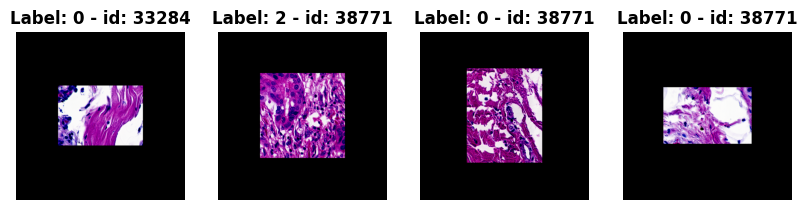

In [49]:
show_imgs([sample["image"][1].permute(1, 2, 0),
           sample["image"][2].permute(1, 2, 0),
           sample["image"][3].permute(1, 2, 0),
           sample["image"][4].permute(1, 2, 0),
           ],
          captions=[f"Label: {sample['label'][1]} - id: {sample['id'][1]}",
                    f"Label: {sample['label'][2]} - id: {sample['id'][2]}",
                    f"Label: {sample['label'][3]} - id: {sample['id'][2]}",
                    f"Label: {sample['label'][4]} - id: {sample['id'][2]}",
                    ])

# Get a pre-trained model
Here I will use the models [from](https://github.com/lunit-io/benchmark-ssl-pathology)

In [50]:
# add Fully connected linear layer
class Resnet_fc(nn.Module):
  def __init__(self, pre_trained_model):
    super(Resnet_fc, self).__init__()
    n_classes = 3
    self.model = pre_trained_model
# Size of the layer if using 226, 226
#    self.fc = nn.Sequential(nn.Flatten(),
#                            nn.Linear(2048*7*7, n_classes))
    self.fc = nn.Sequential(nn.Flatten(),
                             nn.Linear(2048*28*28, n_classes))
  def forward(self, x):
    x = self.model(x)
    x = self.fc(x)
    return x

In [51]:
# Create a last fully connected layer to match the number of classes
# Note: the number of of nodes was determined by looking at the network

num_classes = 3
pre_trained_model = resnet50(pretrained=True, progress=False, key="MoCoV2")

# Freeze the parameters in the pre-trained network
for param in pre_trained_model.parameters():
    param.requires_grad = False

# Add the fully connected layer that we want to optmize
model = Resnet_fc(pre_trained_model)
model.to(device)


<All keys matched successfully>


Resnet_fc(
  (model): ResNetTrunk(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [52]:
# note that only the last parameters will be optimized
optimizer = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)

# Define the loss function
# use weights to balance out the imbalanced classification
weights = [1/n_healthy, 1/n_benign, 1/n_malign]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
#criterion = nn.CrossEntropyLoss()

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, min_lr=1e-4, patience=100)

In [53]:
num_epochs = 100
epoch_loss_list = []
epoch_lr = []
model.train()
for epoch in range(num_epochs):
  running_loss = 0.0
  print('-' * 10)
  for inputs in dataloader:
    images = inputs["image"].to(device)
    labels = inputs["label"].to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    outputs = model(images)
    loss = criterion(outputs, labels)
    running_loss += loss.item()

    loss.backward()
    optimizer.step()
    scheduler.step(loss)

  epoch_loss = running_loss / len(dataloader)
  epoch_loss_list.append(epoch_loss)
  epoch_lr.append(get_lr(optimizer))
  print(f"Epoch {epoch}/{num_epochs} - Loss: {epoch_loss:.4f}")


----------
Epoch 0/200 - Loss: 1.1708
----------
Epoch 1/200 - Loss: 0.6445
----------
Epoch 2/200 - Loss: 0.2972
----------
Epoch 3/200 - Loss: 0.1438
----------
Epoch 4/200 - Loss: 0.0960
----------
Epoch 5/200 - Loss: 0.1468
----------
Epoch 6/200 - Loss: 0.1269
----------
Epoch 7/200 - Loss: 0.0598
----------
Epoch 8/200 - Loss: 0.0408
----------
Epoch 9/200 - Loss: 0.0091
----------
Epoch 10/200 - Loss: 0.0451
----------
Epoch 11/200 - Loss: 0.0056
----------
Epoch 12/200 - Loss: 0.0321
----------
Epoch 13/200 - Loss: 0.0090
----------
Epoch 14/200 - Loss: 0.0074
----------
Epoch 15/200 - Loss: 0.0040
----------
Epoch 16/200 - Loss: 0.0037
----------
Epoch 17/200 - Loss: 0.0156
----------
Epoch 18/200 - Loss: 0.0020
----------
Epoch 19/200 - Loss: 0.0076
----------
Epoch 20/200 - Loss: 0.0053
----------
Epoch 21/200 - Loss: 0.0135
----------
Epoch 22/200 - Loss: 0.0047
----------
Epoch 23/200 - Loss: 0.0036
----------
Epoch 24/200 - Loss: 0.0063
----------
Epoch 25/200 - Loss: 0.0

Text(0, 0.5, 'Loss')

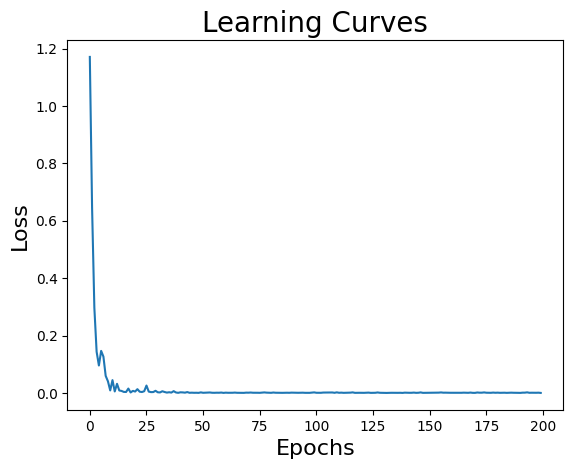

In [54]:
plt.plot(epoch_loss_list)
plt.title("Learning Curves", fontsize=20)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)

Text(0, 0.5, 'Loss')

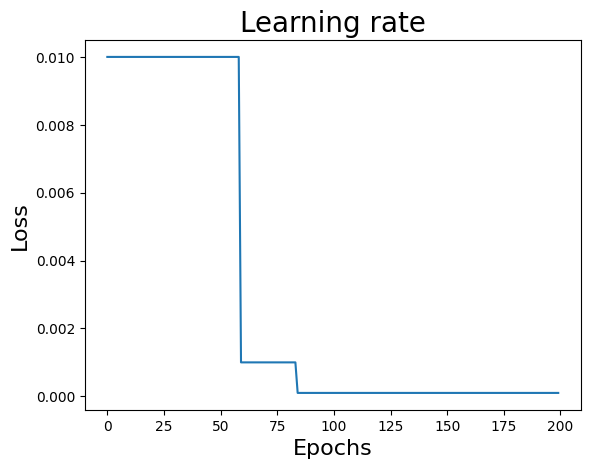

In [55]:
plt.plot(epoch_lr)
plt.title("Learning rate", fontsize=20)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)

# Get the test labels

In [57]:
output = {}

output_df = pd.DataFrame(columns=['id', 'malignant'])
images_files = data_dir.glob("*.png")
# remove files that we have labels for
training_ids = data_df['id'].to_list()
test_ids = []
for idx, image_file in enumerate(images_files):
  id = int(image_file.stem.split('_')[1])
  if id not in training_ids:
    test_ids.append(id)

    # Load image
    image = Image.open(image_file).convert('RGB')
    height, width = get_image_size(image)
    pad = transforms.Pad((int(np.floor((896-height)/2)),
                          int(np.floor((896-width)/2)),
                          int(np.ceil((896-height)/2)),
                          int(np.ceil(896-width)/2)),
                          padding_mode='constant')
    image = pad(image)
    data = transform(image=np.array(image))['image'].to(device)
    # Add Batch dimension
    data = torch.unsqueeze(data, 0)

    # pass image to the model
    label = torch.argmax(model(data)).cpu().detach().numpy() - 1

    output_df.loc[idx] = [id, label]

print(f'Number of unlabelled images: {len(test_ids)}')

Number of unlabelled images: 124


In [ ]:
output_df

In [58]:
output_df[output_df['malignant'] >= 0]

,id,malignant
1,467694,-1
2,812227,-1
3,67212,1
5,346084,-1
6,97549,-1
...,...,...
178,791719,0
180,74995,1
183,957521,1
184,125877,1


In [59]:
output_df['malignant'].value_counts()

-1    67
 1    36
 0    21
Name: malignant, dtype: int64

In [60]:
# save output
output_df = output_df.sort_values('id')
output_df.to_csv(data_dir / 'predictions.csv', index=False)

In [80]:
# acc: 0.54
second_pred = pd.read_csv(data_dir / 'second_submission_predictions.csv')
print(second_pred['malignant'].value_counts())
second_pred[second_pred['malignant'] >= 0]

-1    72
 0    35
 1    17
Name: malignant, dtype: int64


,id,malignant
2,35946,1
6,49868,1
8,67212,0
10,74995,0
11,76700,0
13,93671,1
19,125877,0
21,133962,0
22,136044,0
23,139077,1


In [72]:
# acc: 0.61
third_pred = pd.read_csv(data_dir / 'thrid_submission_predictions')
third_pred[third_pred['malignant'] >= 0]